# Deep Computer Vision using Convolutional Neural Networks
In this notebook we will be implementing CNN using Tensorflow and Keras, CNN architectures and their building blocks, and performing tasks like object detection and semantic segmentation.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale and RGB images:

In [2]:
# grayscale image
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

# RGB image
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Convolutional Layers

### How does it work? 
![CNN layers](images/cnn_layers.jpeg)

Neurons in first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on.

#### Step 1 - Prepare a dataset of images
![CNN layers](images/cnn_layers_2.png)
* Every image is a matrix of pixel values.
* The range of values that can be encoded in each pixel depends upon its bit size.
* Most commonly, we have 8 bit or 1 Byte-sized pixels. Thus the possible range of values a single pixel can represent is [0, 255].
* However, with coloured images, particularly RGB (Red, Green, Blue)-based images, the presence of separate colour channels (3 in the case of RGB images) introduces an additional ‘depth’ field to the data, making the input 3-dimensional.
* Hence, for a given RGB image of size, say 255×255 (Width x Height) pixels, we’ll have 3 matrices associated with each image, one for each of the colour channels.
* Thus the image in it’s entirety, constitutes a 3-dimensional structure called the Input Volume (255x255x3).

#### Step 2 - Convolution
A convolution is a mathematical operation that slides one function over another and measures the integral of their pointwise multiplication.
![CNN layers](images/cnn_layers_3.png)

* A convolution is an orderly procedure where two sources of information are intertwined.

* A kernel (also called a filter) is a smaller-sized matrix in comparison to the input dimensions of the image, that consists of real valued entries.

* Kernels are then convolved with the input volume to obtain so-called ‘activation maps’ (also called feature maps).

* Activation maps indicate ‘activated’ regions, i.e. regions where features specific to the kernel have been detected in the input.

* The real values of the kernel matrix change with each learning iteration over the training set, indicating that the network is learning to identify which regions are of significance for extracting features from the data.

* We compute the dot product between the kernel and the input matrix. -The convolved value obtained by summing the resultant terms from the dot product forms a single entry in the activation matrix.

* The patch selection is then slided (towards the right, or downwards when the boundary of the matrix is reached) by a certain amount called the ‘stride’ value, and the process is repeated till the entire input image has been processed. - The process is carried out for all colour channels.

* instead of connecting each neuron to all possible pixels, we specify a 2 dimensional region called the ‘receptive field[14]’ (say of size 5×5 units) extending to the entire depth of the input (5x5x3 for a 3 colour channel input), within which the encompassed pixels are fully connected to the neural network’s input layer. It’s over these small regions that the network layer cross-sections (each consisting of several neurons (called ‘depth columns’)) operate and produce the activation map. (reduces computational complexity)

##### Filters
Below we will define 2 weights, the first one is represented as a black square with vertical white line in the middle (7x7 matrix full of 0s except for the central column, which is full of 1s) and second filter is a black square with a horizontal white line in the middle. 

When it gets multiplied with the receptive field it ignores everything except the vertical and horizontal line respectively. Thus, a layer full of neurons using the same filter outputs a **feature map** which highlights the areas in an image that activate the filter the most.

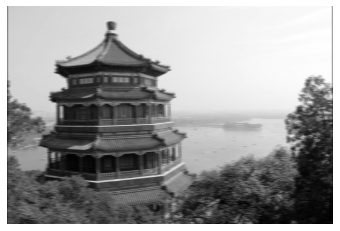

In [44]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255 # scaling the features by dividing it with 255 to get value between 0 to 1
flower = load_sample_image("flower.jpg") / 255

images = np.array([china, flower]) # 4D tensor
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # 4D tensor


filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") # zero padding

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

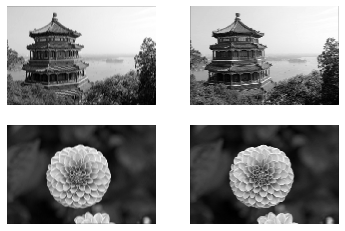

In [45]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

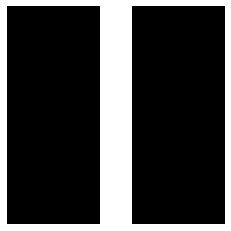

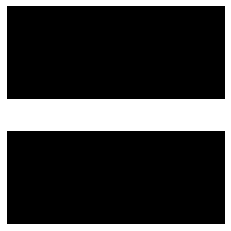

In [46]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Saving figure v_image


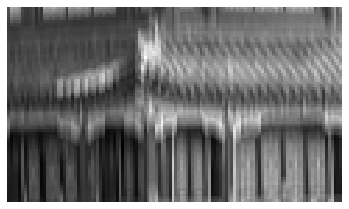

Saving figure h_image


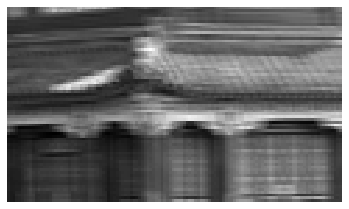

In [61]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(outputs[0, :, :, 0]))
save_fig('v_image', tight_layout=False)
plt.show()

plot_image(crop(outputs[0, :, :, 1]))
save_fig('h_image', tight_layout=False)
plt.show()

Using keras.layers.Conv2D():

*In a real CNN you would normally define filters as trainable variables.*

In [48]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

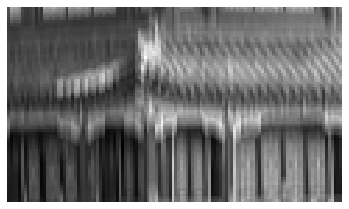

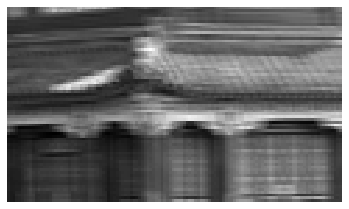

In [51]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()
plot_image(crop(outputs[0, :, :, 1]))
plt.show()

#### Step 3: Pooling
![Pooling](images/pooling.png)

* Pooling reducing the spatial dimensions (Width x Height) of the Input Volume for the next Convolutional Layer. It does not affect the depth dimension of the Volume.
* The transformation is either performed by taking the maximum value from the values observable in the window (called ‘max pooling’), or by taking the average of the values. Max pooling has been favoured over others due to its better performance characteristics.
* also called downsampling

##### Max Pooling

In [52]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # use AvgPool2D for average pooling

In [57]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


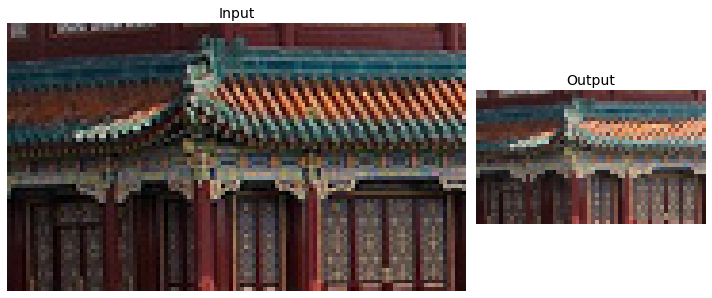

In [62]:
fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

##### Depth-wise pooling

In [72]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
    def call(self, inputs):
        return tf.nn.max_pool(inputs, 
                              ksize = (1,1,1,3),
                              strides = (1,1,1,3),
                              padding = 'VALID')

In [74]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a Lambda layer:

In [76]:
depth_pool = keras.layers.Lambda(lambda X:
                                tf.nn.max_pool(X, ksize=(1,1,1,3),
                                              strides=(1,1,1,3),
                                              padding='VALID'))

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

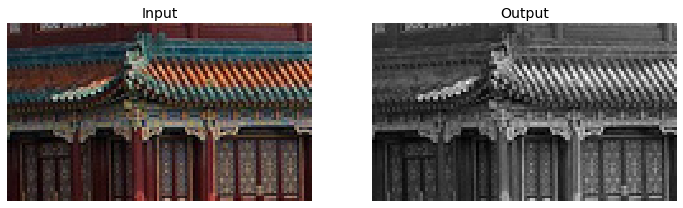

In [77]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

##### Average Pooling

In [91]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

##### Global Average Pooling

In [92]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

or the Lambda layer:

In [93]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

#### Step 4 - Normalization (ReLU in our case)

* Normalization (keep the math from breaking by turning all negative numbers to 0) (RELU) a stack of images becomes a stack of images with no negative values.

* Repeat Steps 2-4 several times. More, smaller images (feature maps created at every layer)

#### Step 5 - Regularization
* Dropout forces an artificial neural network to learn multiple independent representations of the same data by alternately randomly disabling neurons in the learning phase.
* Dropout is a vital feature in almost every state-of-the-art neural network implementation.
* To perform dropout on a layer, you randomly set some of the layer's values to 0 during forward propagation.

#### Step 6 - Probability Conversion (Softmax)
At the very end of our network (the tail), we'll apply a softmax function to convert the outputs to probability values for each class.

#### Step 7 - Choose most likely label (max probability value)
argmax(softmax_outputs)

These 7 steps are one forward pass through the network.

## CNN Architectures

In [97]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [103]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='SAME')

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    # regular feedforward network
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [104]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 555s 323ms/step - loss: 0.7070 - accuracy: 0.7542 - val_loss: 0.3797 - val_accuracy: 0.8666
Epoch 2/10
1719/1719 [==============================] - 1249s 726ms/step - loss: 0.4270 - accuracy: 0.8556 - val_loss: 0.3253 - val_accuracy: 0.8790
Epoch 3/10
1719/1719 [==============================] - 624s 363ms/step - loss: 0.3673 - accuracy: 0.8746 - val_loss: 0.3130 - val_accuracy: 0.8870
Epoch 4/10
1719/1719 [==============================] - 1484s 864ms/step - loss: 0.3350 - accuracy: 0.8874 - val_loss: 0.2935 - val_accuracy: 0.8928
Epoch 5/10
1719/1719 [==============================] - 569s 331ms/step - loss: 0.3151 - accuracy: 0.8938 - val_loss: 0.3007 - val_accuracy: 0.8932
Epoch 6/10
1719/1719 [==============================] - 3675s 2s/step - loss: 0.2951 - accuracy: 0.8986 - val_loss: 0.2919 - val_accuracy: 0.8958
Epoch 7/10
1719/1719 [==============================] - 534s 310ms/step - loss: 0.2803 - accuracy: 0.9048 - val_

## Implementing a RESNET-34 CNN using Keras

In [110]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
        # main layers
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        
        
        # skip layers
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(inputs)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(Z)
        return self.activation(Z + skip_Z)

In [117]:
model = keras.models.Sequential()

model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3], padding='SAME', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: 
    strides = 1 if filters == prev_filter else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dense(10, activation='softmax'))

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Models from Keras

In general you won't have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code.

For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [119]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 15s 0us/step


To use it you need to ensure that the images have the right size (Here, ResNet expects 224 x 224 pixel images). Hence we need to resize the images:

In [127]:
images_resized = tf.image.resize(images, [224, 224])

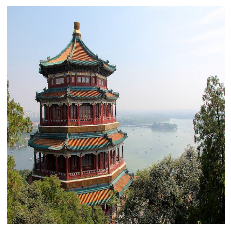

In [128]:
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


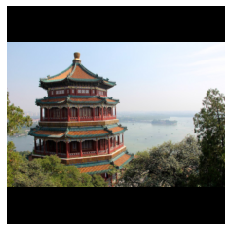

In [132]:
# resize with padding
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

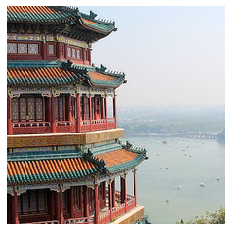

In [133]:
# resizing with cropping
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

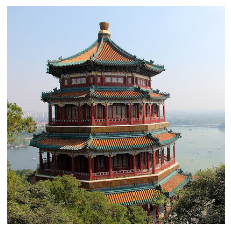

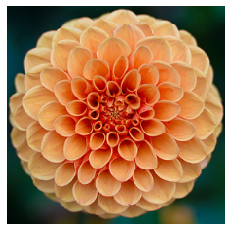

In [134]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

The pretrained models assume that the images are preprocessed in a specific way (0 to 1, or -1 to 1, and so on). Each model provides a `preprocess_input()` function. that can be used to preprocess images. 

Earlier we scaled them to 0 to 1. Hence, multiplying with 255:

In [135]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [139]:
Y_proba = model.predict(inputs)

In [141]:
Y_proba.shape # output is 1 row per image and 1000 classes.

(2, 1000)

Displaying the top K predictions:

In [142]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
    print('Image #{}'.format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(' {} - {:12s} {:.2f}%'.format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.07%
 n03781244 - monastery    11.70%

Image #1
 n04522168 - vase         53.96%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.97%

